In [1]:
from ms2query.ms2library import MS2Library
from ms2query.utils import load_pickled_file
import os

root_path = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data/libraries_and_models/gnps_15_12_2021"

test_spectra_3000 = load_pickled_file(os.path.join(root_path, "in_between_files", "GNPS_15_12_2021_pos_test_3000_spectra.pickle"))
test_spectra_250 = load_pickled_file(os.path.join(root_path, "in_between_files", "GNPS_15_12_2021_pos_test_250_inchikeys.pickle"))

tanimoto_scores_df_file = os.path.join(root_path, "in_between_files", "GNPS_15_12_2021_pos_tanimoto_scores.pickle")
sqlite_file = os.path.join(root_path, "library_gnps_15_12", "library_GNPS_15_12_2021.sqlite")


c:\users\jonge094\anaconda3\envs\ms2query\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Generating data

### Library search using cosine score

In [1]:
from ms2query.query_from_sqlite_database import get_precursor_mz_within_range, get_spectra_from_sqlite
from matchms.calculate_scores import calculate_scores
from matchms.similarity.CosineGreedy import CosineGreedy
from tqdm.notebook import tqdm
import numpy as np

MASS_TOLERANCE = 1
MINIMAL_COS = 0.6


matches_for_test_spectra= []
for test_spectrum in tqdm(test_spectra_3000):
    # Select spectra within mass tolerance
    precursor_mz = test_spectrum.get("precursor_mz")
    selected_lib_spec_and_mass = get_precursor_mz_within_range(sqlite_file, precursor_mz-MASS_TOLERANCE, precursor_mz+MASS_TOLERANCE)
    selected_lib_spec_ids = [spectrum_id[0] for spectrum_id in selected_lib_spec_and_mass]
    selected_lib_spectra = get_spectra_from_sqlite(sqlite_file, selected_lib_spec_ids)
    # Calculate cosine score
    scores = calculate_scores(selected_lib_spectra, [test_spectrum], CosineGreedy())
    
    matches = []
    for score in scores:
        (reference, query, score) = score
        if score["score"] >= MINIMAL_COS:
            matches.append([reference, score["score"]])
    matches_for_test_spectra.append(matches)

c:\users\jonge094\anaconda3\envs\ms2query\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


NameError: name 'test_spectra_3000' is not defined

In [4]:
import pickle
pickle.dump(matches_for_test_spectra, open(os.path.join(root_path, "test_results_lib_search_using_cos_score.pickle"), "wb"))

In [ ]:
def select_best_match_and_calculate_tanimoto_score(query_spectra,
                                                   results, 
                                                   tanimoto_scores_file, 
                                                   sqlite_file_location):
    """Returns a list with all the cosine scores and tanimoto scores for the best matches"""

    tanimoto_scores = load_pickled_file(tanimoto_scores_file)
    ms2query_scores_and_tanimoto = []
    
    for query_spectrum_id, result in enumerate(results): 
        query_spectrum = query_spectra[query_spectrum_id]
        query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]

        # select highest scoring match
        
        best_match_inchikey = get_metadata_from_sqlite(
            sqlite_file_location, [best_match_spectrum_id], "spectrumid")[best_match_spectrum_id]["inchikey"][:14]
        tanimoto_score = tanimoto_scores.loc[best_match_inchikey, query_spectrum_inchikey]

        ms2query_scores_and_tanimoto.append((best_match_score, tanimoto_score))
    return ms2query_scores_and_tanimoto

### Analog search using modified cosine score

In [3]:
from ms2query.query_from_sqlite_database import get_spectra_from_sqlite

all_lib_spectra = get_spectra_from_sqlite(sqlite_file, [], get_all_spectra=True)

NameError: name 'selected_lib_spectra' is not defined

## The code below was run in a python script instead

In [17]:
from matchms.calculate_scores import calculate_scores
from matchms.similarity.ModifiedCosine import ModifiedCosine
from tqdm.notebook import tqdm


def select_spectra_within_mass_range(spectra, lower_bound, upper_bound):
    selected_spectra = []
    for spectrum in spectra:
        precursor_mz = spectrum.get('precursor_mz')
        if precursor_mz <= upper_bound and precursor_mz >= lower_bound:
            selected_spectra.append(spectrum)
    return selected_spectra

def analogue_search(lib_spectra, test_spectra, mass_tolerance = 100, minimal_mod_cos = 0.7):
    matches_for_test_spectra = []
    for test_spectrum in tqdm(test_spectra):
        precursor_mz = test_spectrum.get("precursor_mz")
        selected_lib_spectra = select_spectra_within_mass_range(lib_spectra, precursor_mz-mass_tolerance, precursor_mz+mass_tolerance)
        scores = calculate_scores(selected_lib_spectra, [test_spectrum], ModifiedCosine())
        matches = []
        for score in scores:
            (reference, query, score) = score
            if score["score"] >= minimal_mod_cos:
                matches.append([reference, score["score"]])
        matches_for_test_spectra.append(matches)
    return matches_for_test_spectra

# Plot results

In [1]:
from ms2query.utils import load_pickled_file

results_analogue_search = load_pickled_file("C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data/libraries_and_models/gnps_15_12_2021/benchmarking/test_results_analog_search_mod_cos.pickle")

c:\users\jonge094\anaconda3\envs\ms2query\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
import os
root_path = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data/libraries_and_models/gnps_15_12_2021"
test_spectra_250 = load_pickled_file(os.path.join(root_path, "in_between_files", "GNPS_15_12_2021_pos_test_250_inchikeys.pickle"))


In [14]:
def select_highest_scoring_matches(results_analogue_search):
    best_matches = []
    for result in results_analogue_search:
        if len(result) > 0:
            cos_scores = [single_match[1] for single_match in result]
            index_max = cos_scores.index(max(cos_scores))
            highest_scoring_lib_spec = result[index_max][0]
            best_matches.append(highest_scoring_lib_spec)
        else:
            best_matches.append(None)
    return best_matches

In [15]:
highest_scoring_matches = select_highest_scoring_matches(results_analogue_search)

In [20]:
tanimoto_scores = load_pickled_file(os.path.join(root_path, "in_between_files", "GNPS_15_12_2021_pos_tanimoto_scores.pickle"))

In [25]:
from tqdm.notebook import tqdm

def calculate_tanimoto_score(query_spectra, matches, tanimoto_scores):
    results = []
    for i in tqdm(range(len(query_spectra))):
        query_spectrum = query_spectra[i]
        lib_spectrum = matches[i]
        if lib_spectrum is None:
            tanimoto_scores.append(None)
        else:
            query_inchikey = query_spectrum.get("inchikey")[:14]
            lib_inchikey = lib_spectrum.get('inchikey') [:14]
            tanimoto_score = tanimoto_scores.loc[query_inchikey, lib_inchikey]
            results.append(tanimoto_score)
    return results

In [26]:
resulting_scores = calculate_tanimoto_score(test_spectra_250, highest_scoring_matches, tanimoto_scores)

  0%|          | 0/2987 [00:00<?, ?it/s]

In [28]:
import pickle
pickle.dump(resulting_scores, open(os.path.join(root_path, "benchmarking", "tanimoto_scores_benchmarking_mod_cos_analog_search.pickle"), "wb"))

In [38]:
i = 0
for result in highest_scoring_matches:
    if result is None:
        i += 1
print(i)

176


In [36]:
print(len(resulting_scores))

2811


In [39]:
print(len(test_spectra_250))

2987


In [42]:
import numpy as np
from matplotlib import pyplot as plt

def compare_tanimoto_score_distribution(tanimoto_scores, total_spectra):
    bins = np.linspace(0, 1, 11)
    
    # remove Nones
    tanimoto_scores = [score for score in tanimoto_scores if score is not None]
    percentage_selected = len(tanimoto_scores)/total_spectra*100
    print("MS2query percentage found")
    print(percentage_selected)
    weight_to_convert_to_percentage = 100/total_spectra
    weights = [weight_to_convert_to_percentage] * len(tanimoto_scores)
    
    plt.hist([tanimoto_scores], bins, 
             label = ["modified cosine score"], weights = [weights])
    
    plt.legend(loc = "upper center", title = "Select on:")
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0, 25)

    plt.show

MS2query percentage found
94.10780046869769


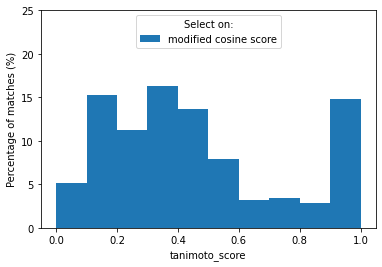

In [43]:
compare_tanimoto_score_distribution(resulting_scores, 2987)

# to do
Maybe rerun, but only select the top hit, to make comparison accross the whole range. 
Also run tests for MS2Deepscore and MS2Query
MS2Deepscore + precursor m/z difference? 
